In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import csv
import os
from scipy.signal import butter, filtfilt
import scipy
#from PyEMD import EMD
import emd
import time
import pywt
import biosppy.signals.ecg as bsp_ecg
import biosppy.signals.tools as bsp_tools
from scipy.signal import medfilt
from scipy.signal import firwin, lfilter

from utils import print_signal_qrs, print_signal, calcul_f1, perf

In [33]:
def apply_fir_filter(signal, sample_rate):
    lowcut = 0.5     
    highcut = 40.0 
    filter_order = 64
    # Calcul des fréquences normalisées
    nyquist_rate = sample_rate / 2.0
    low = lowcut / nyquist_rate
    high = highcut / nyquist_rate
    
    # Coefficients du filtre FIR
    fir_coeff = firwin(filter_order + 1, [low, high], pass_zero=False)
    
    # Filtrage
    filtered_signal = lfilter(fir_coeff, 1.0, signal)
    return filtered_signal

def temporal_difference(signal, k):
    # Initialisation du résultat
    output = np.zeros_like(signal)
    
    # Calcul de x(n) = w(n) - w(n-k)
    output[k:] = signal[k:] - signal[:-k]
    return output

def multiple(ecg_signal):
    enhanced_signal = (2 * ecg_signal) ** 3
    return enhanced_signal

def moving_average(a, fs, size_window):
    ret = np.cumsum(a, dtype=float)
    ret[size_window:] = ret[size_window:] - ret[:-size_window]
    return ret[size_window - 1:] / size_window

from scipy.signal import medfilt

def remove_baseline_drift(ecg_signal, sampling_frequency):
    window_size_1 = sampling_frequency if sampling_frequency % 2 != 0 else sampling_frequency + 1
    baseline_estimation_1 = medfilt(ecg_signal, kernel_size=window_size_1)
    window_size_2 = 2 * sampling_frequency if 2 * sampling_frequency % 2 != 0 else 2 * sampling_frequency + 1
    baseline_estimation_2 = medfilt(baseline_estimation_1, kernel_size=window_size_2)
    drift_removed_signal = ecg_signal - baseline_estimation_2

    return drift_removed_signal

def normalize_operation(signal):
    return (signal - np.mean(signal)) / np.std(signal, ddof=1)
    #return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

In [38]:
def fir_filter(ecg_signal, fs):
    low_cutoff = 0.5
    high_cutoff = 40.0
    
    # Ordre du filtre FIR
    filter_order = 5
    
    # Coefficients du filtre FIR (bandpass)
    nyq = 0.5 * fs
    low = low_cutoff / nyq
    high = high_cutoff / nyq
    
    # Design du filtre (fenêtre Hamming)
    fir_coeffs = scipy.signal.firwin(filter_order, [low, high], pass_zero=False, window='hamming')

    filtered_signal = scipy.signal.lfilter(fir_coeffs, 1.0, ecg_signal)
    
    # Étape 2 : Centrage du signal
    centered_signal = filtered_signal - np.mean(filtered_signal)
    #preprocessed_signal = apply_difference(centered_signal, k)
    return centered_signal

def apply_difference(input_signal, k):
    shifted_signal = np.roll(input_signal, k)
    return input_signal - shifted_signal

signal de longueur: 3000


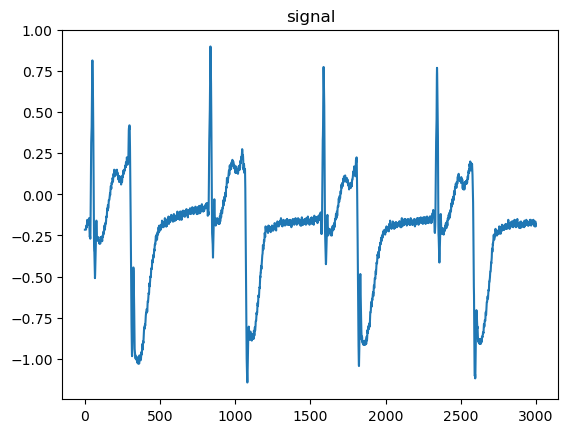

signal de longueur: 3000


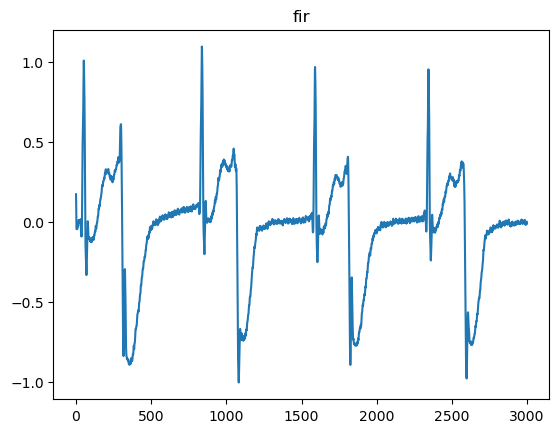

signal de longueur: 3000


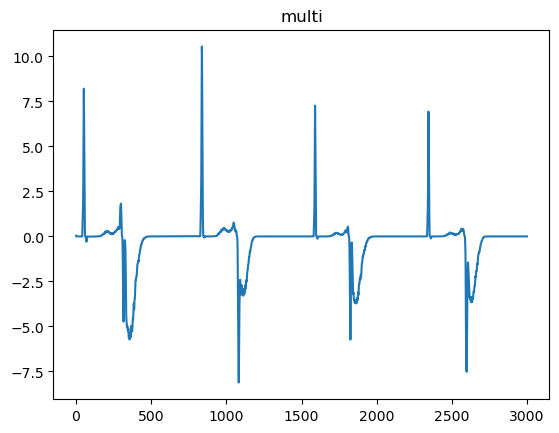

signal de longueur: 3000


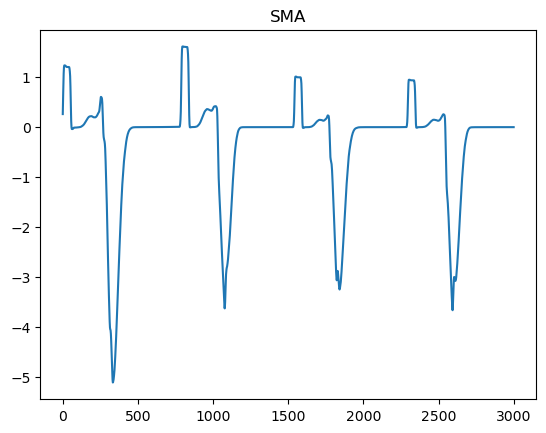

signal de longueur: 3000


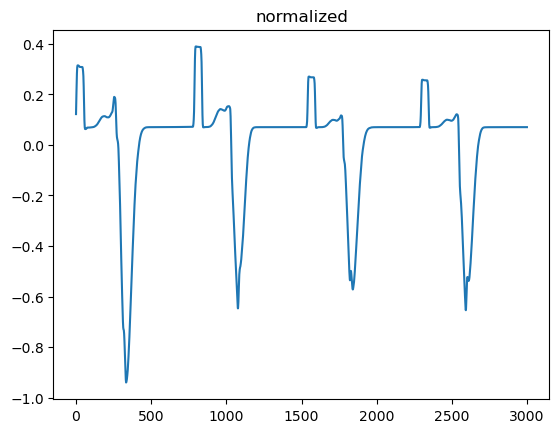

signal de longueur: 3000


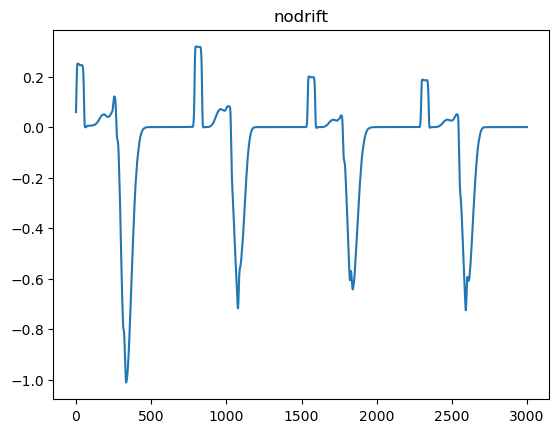

signal de longueur: 3000


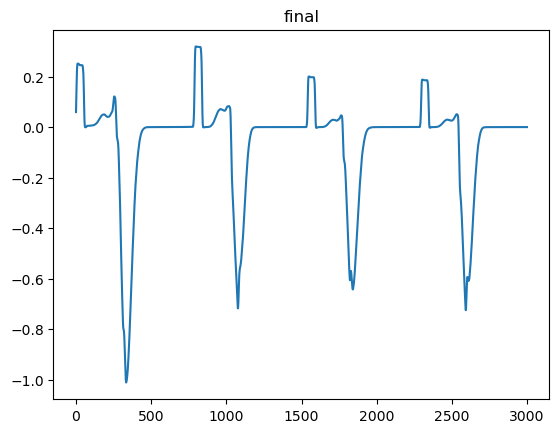

In [235]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:1000]
fs = 360 
XXX = 3000
QRS = df["labels"].dropna().astype(int).tolist()
print_signal(ecg_signal[:XXX], "signal")

#filtered_signal = apply_fir_filter(ecg_signal, fs)
filtered_signal = fir_filter(ecg_signal, fs)
print_signal(filtered_signal[:XXX], "fir")
multi_signal = multiple(filtered_signal)
print_signal(multi_signal[:XXX], "multi")
SMA = moving_average(multi_signal, fs, int(0.14*fs))#round(fs * 0.12)) # 0.12 = taille d'un complexe QRS
print_signal(SMA[:XXX], "SMA")
normalized_signal = normalize_operation(SMA)
print_signal(normalized_signal[:XXX], "normalized")
clean_signal = remove_baseline_drift(normalized_signal, fs)
print_signal(clean_signal[:XXX], "nodrift")
final_signal = clean_signal #np.abs(clean_signal)
print_signal(final_signal[:XXX], "final")

In [236]:
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def thu_update(alpha, peak, thu):                          # (17)
    return alpha * peak + (1 - (4 * alpha)) * thu

def thu_adjust(alpha, thu, previous_thu):                  # (18)
    return thu + (alpha/2) * abs(previous_thu - thu)

def thd_update(alpha, peak, thd):                          # (17)
    return alpha * peak + (1 - (4 * alpha)) * thd

def thd_adjust(alpha, thu, previous_thd):                  # (18)
    return thd - (alpha/2) * abs(previous_thd - thd)

# Théorie :
"""def thd_adjust(alpha, thd, previous_thd):                  # (19)
    print(f"down adjust, from {previous_thd} to {thd - ( (alpha/4) * abs(previous_thd - thd) )}")
    return thd - ( (alpha/4) * abs(previous_thd - thd) )"""

'def thd_adjust(alpha, thd, previous_thd):                  # (19)\n    print(f"down adjust, from {previous_thd} to {thd - ( (alpha/4) * abs(previous_thd - thd) )}")\n    return thd - ( (alpha/4) * abs(previous_thd - thd) )'

In [237]:
def qrs_localization(h, threshold):
    qrs_indices = []
    sous_groupe = []
    for i in range(len(h)):
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= int(fs*0.2): # 36 = valeur donnée dans l'article
            qrs_indices.append(int(np.median(sous_groupe)))
            #max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(int(np.median(sous_groupe)))
        #max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices
    
"""def qrs_localization(h, seuil_up):
    qrs_indices = []
    i = 0
    while i < len(h):
        if h[i] >= seuil_up:
            qrs_indices.append(i)
            i += int(0.12 * fs)
        i += 1
    return qrs_indices"""

'def qrs_localization(h, seuil_up):\n    qrs_indices = []\n    i = 0\n    while i < len(h):\n        if h[i] >= seuil_up:\n            qrs_indices.append(i)\n            i += int(0.12 * fs)\n        i += 1\n    return qrs_indices'

In [246]:
def QRS_detector(signal, fs):
    group_width=0.36

    three_seconds = signal[:int(3 * fs)]
    
    frequency, bin_edges = np.histogram(three_seconds, bins=np.arange(min(three_seconds), max(three_seconds) + group_width, group_width))
    
    fd = frequency / group_width
    
    mu = np.max(fd)
    
    mu_index = np.argmax(fd)
    
    center_value_of_mu = (bin_edges[mu_index] + bin_edges[mu_index + 1]) / 2
    
    Base_i = center_value_of_mu / 4

    thi = rms(signal[:fs*3])

    thu = 0.1
    thd = -0.02 #Base_i - thi
    
    r_peaks = qrs_localization(np.abs(signal), thu) #, thd)
    RR_mean = np.mean(np.diff(r_peaks))

    #XOXO = 45000
    #mini = 35000
    #print_signal_qrs_c(signal[mini:XOXO], [a - mini for a in r_peaks if a < XOXO and a > mini], [a - mini for a in QRS if a < XOXO and a > mini], description = 'a')
    #print([a - mini for a in r_peaks if a < XOXO and a > mini])
    #print([a - mini for a in QRS if a < XOXO and a > mini])
    #print(r_peaks)
    #print(perf(QRS, r_peaks, 36)[:-1])

    thu = Base_i + (thi/2)
    thd = Base_i - thi
    PRP = r_peaks[:5]
    PRPamp = [signal[a] for a in r_peaks[:5]]
    l_thu = [thu] * r_peaks[4]
    l_thd = [thd] * r_peaks[4]
    tempo = r_peaks[4]
    for i in r_peaks[5:]:
        l_thu.extend([thu] * (i - tempo))
        l_thd.extend([thd] * (i - tempo))
        tempo = i
        peak_loc = i 
        peak = signal[i]
        if signal[i] >= thu:
            PRPamp.append(peak)
            PRP.append(peak_loc)
            if PRP[-1] - PRP[-2] > 1.5 * PRP[-3] - PRP[-4]: #RR_mean
                sublist = signal[PRP[-2] + int(0.3*fs) : PRP[-1] - int(0.3*fs)]
                if len(sublist) == 0:
                    continue
                sublist = np.abs(sublist)
                peak_temp = max(sublist)
                loc_temp = np.argmax(sublist) + i
                if peak_temp >= thu:
                    alpha = 0.125
                    thu = thu_update(alpha, peak_temp, thu)
                    PRPamp.append(peak_temp)
                    PRP.append(loc_temp)
                elif PRP[-1] - PRP[-2] < round(0.4 * fs):
                    alpha = 0.062
                    thu = thu_update(alpha, peak_temp, thu)
                    PRP.pop()
                    PRPamp.pop()
        elif signal[i] < thd:
            PRPamp.append(peak)
            PRP.append(peak_loc)
            if PRP[-1] - PRP[-2] > 1.5 * PRP[-3] - PRP[-4]:
                sublist = signal[PRP[-2] + int(0.3*fs) : PRP[-1] - int(0.3*fs)]
                if len(sublist) == 0:
                    continue
                sublist = np.abs(sublist)
                peak_temp = max(sublist)
                loc_temp = np.argmax(sublist) + i
                if peak_temp <= abs(thd):
                    PRPamp.append(peak_temp)
                    PRP.append(loc_temp)
                elif PRP[-1] - PRP[-2] < round(0.4 * fs):
                    alpha = 0.062
                    thd = thd_adjust(alpha, peak_temp, thd)
                    PRP.pop()
                    PRPamp.pop()


    l_thu.extend([thu] * (len(signal) - len(l_thu) )) 
    l_thu.extend([thd] * (len(signal) - len(l_thd) )) 
    return PRP, l_thu, l_thd

r_peaks, seuil_up, seuil_d = QRS_detector(final_signal, fs)
perf(QRS, r_peaks, 36, True)

(1336,
 309,
 1021,
 [array([ 9, 27, 50]),
  array([7191]),
  array([7937]),
  array([8694]),
  array([9372]),
  array([9463]),
  array([10196]),
  array([10939]),
  array([12376]),
  array([12436]),
  array([13200]),
  array([13348]),
  array([13717]),
  array([13868]),
  array([13967]),
  array([14125]),
  array([14263]),
  array([14414]),
  array([14522]),
  array([14619]),
  array([14894]),
  array([15018]),
  array([15258]),
  array([15387]),
  array([15519]),
  array([15642]),
  array([15759]),
  array([15906]),
  array([16015]),
  array([16138]),
  array([16262]),
  array([16383]),
  array([16496]),
  array([16611]),
  array([16710]),
  array([16822]),
  array([16936]),
  array([17055]),
  array([17218]),
  array([17346]),
  array([17509]),
  array([17618]),
  array([17730]),
  array([17857]),
  array([17903]),
  array([17976]),
  array([18132]),
  array([18256]),
  array([18350]),
  array([18396]),
  array([19070]),
  array([19579]),
  array([19715]),
  array([19760]),
  array(

In [239]:
109,
 38,
 2267,

IndentationError: unexpected indent (2584247385.py, line 2)

In [247]:
len(r_peaks)

1623

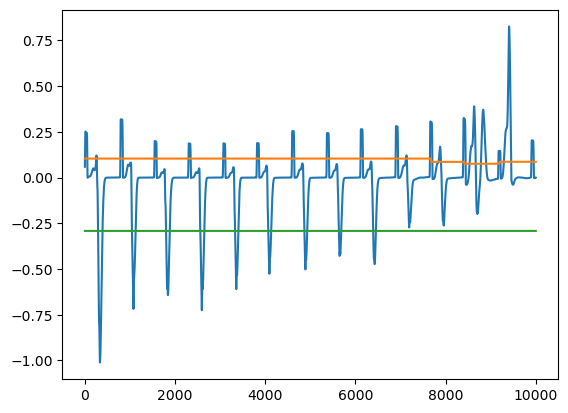

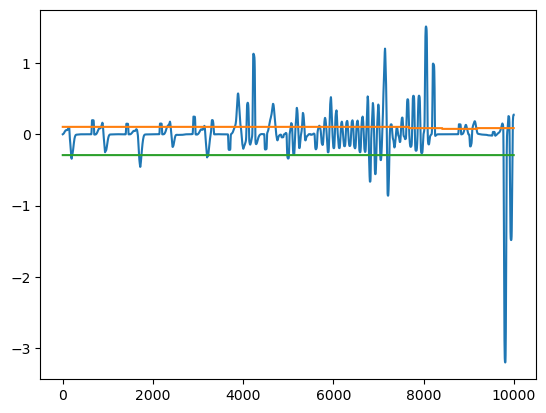

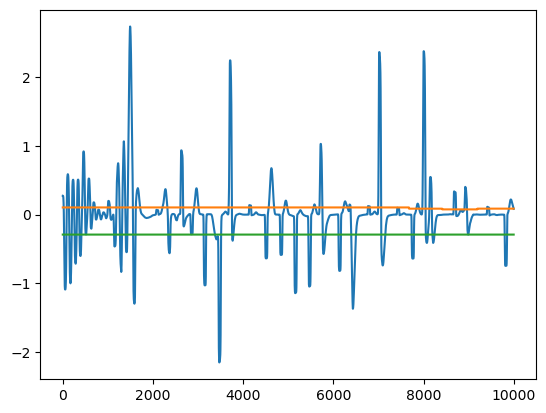

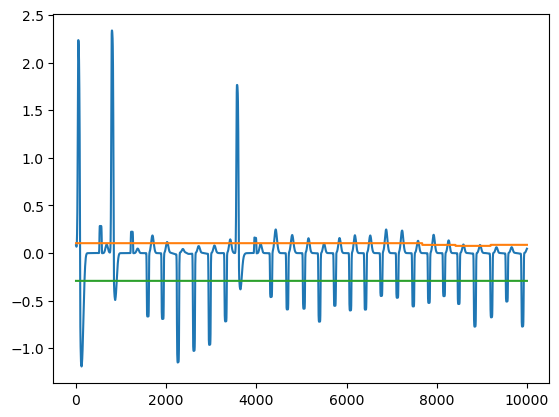

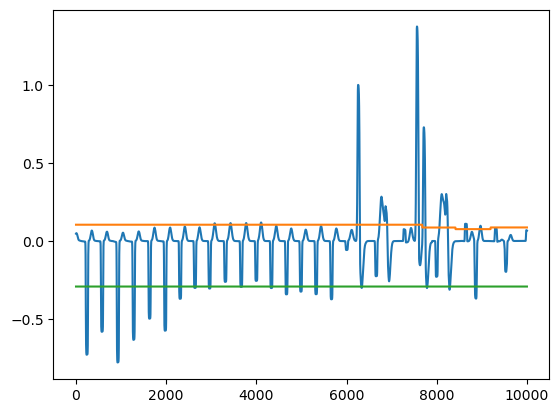

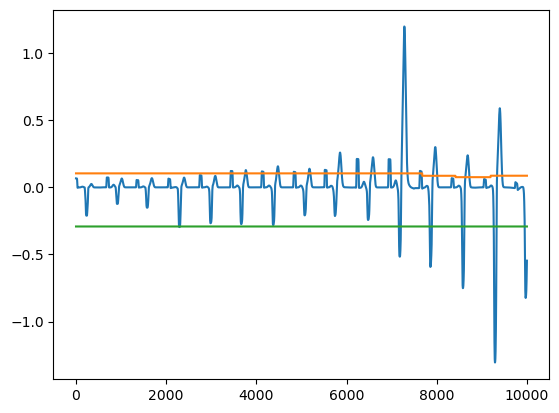

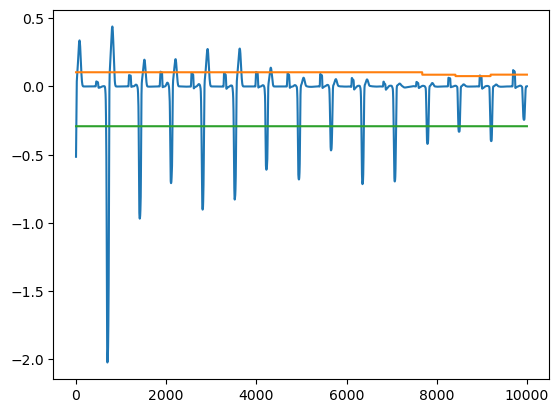

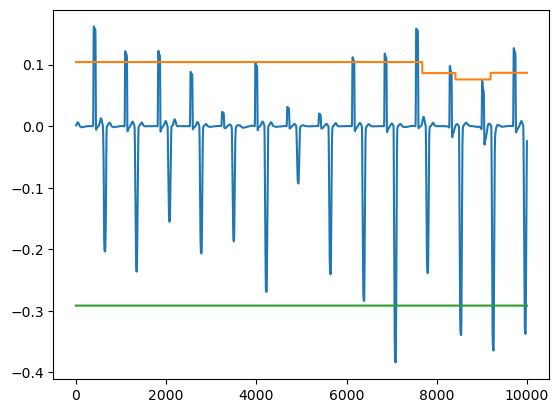

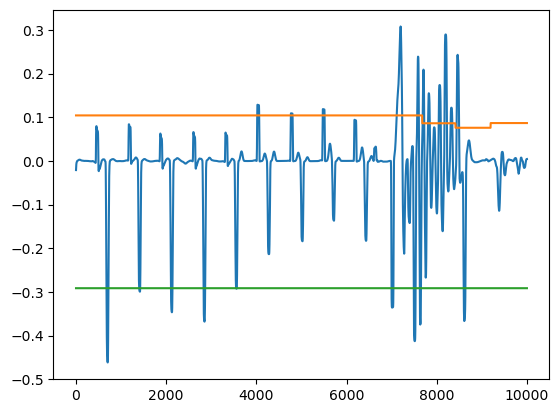

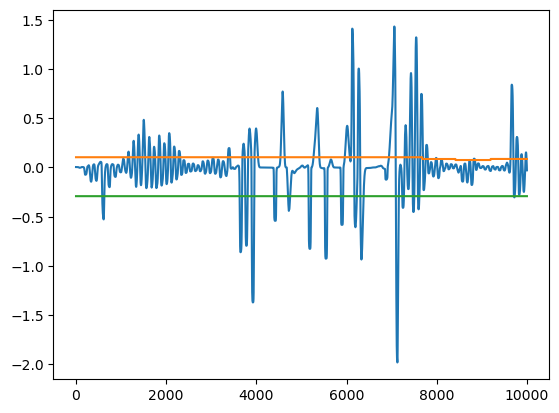

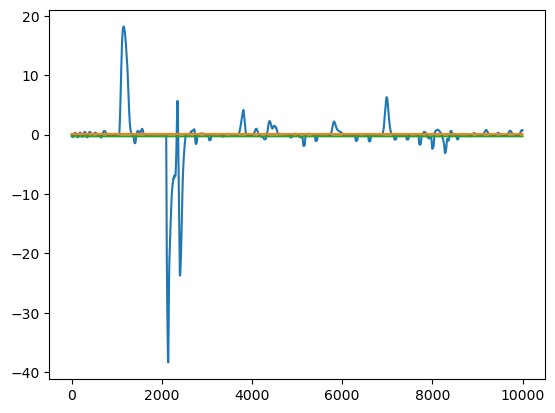

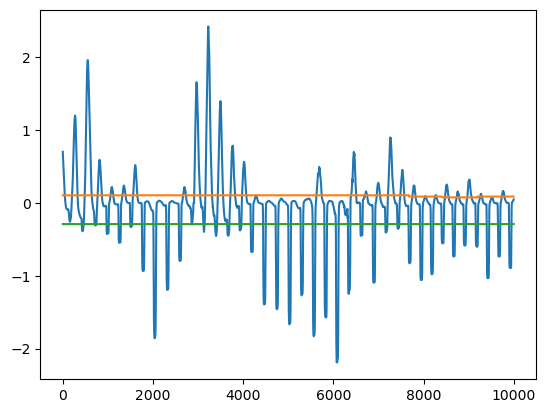

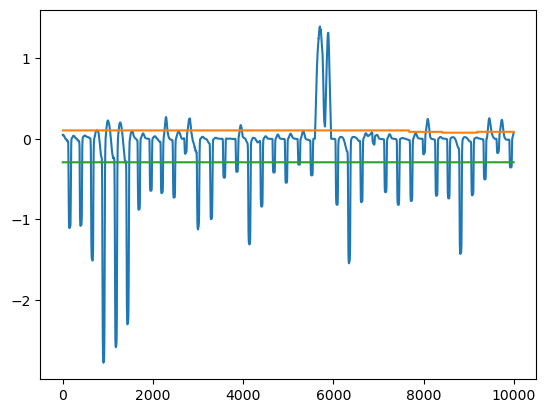

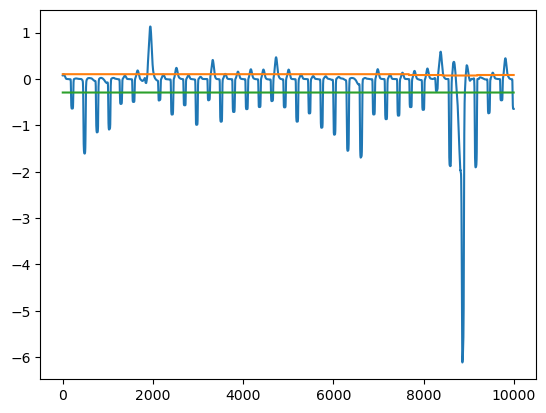

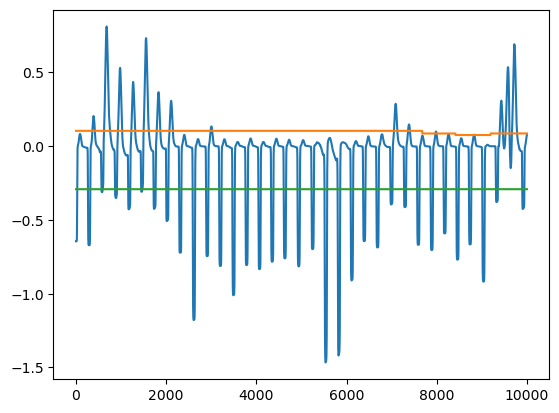

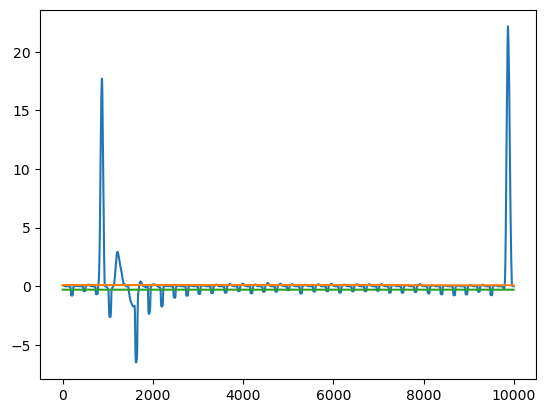

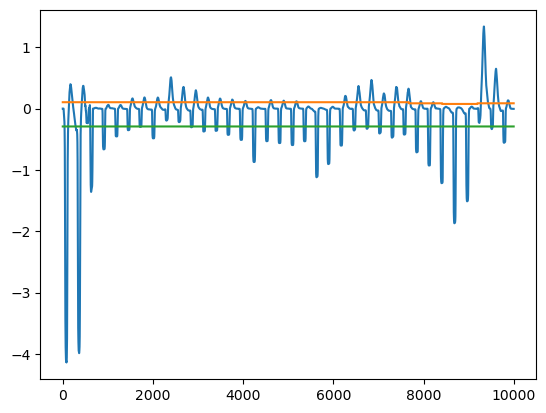

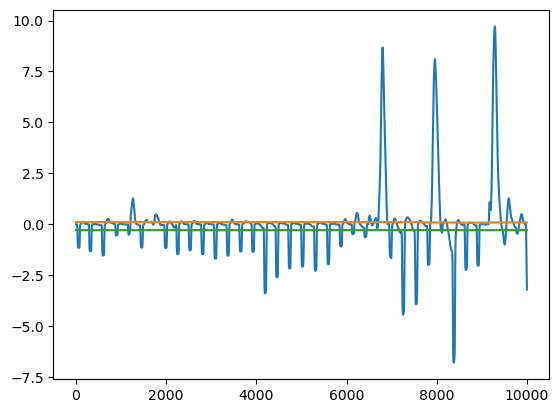

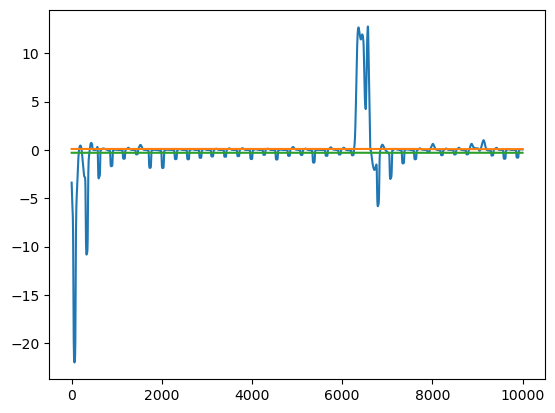

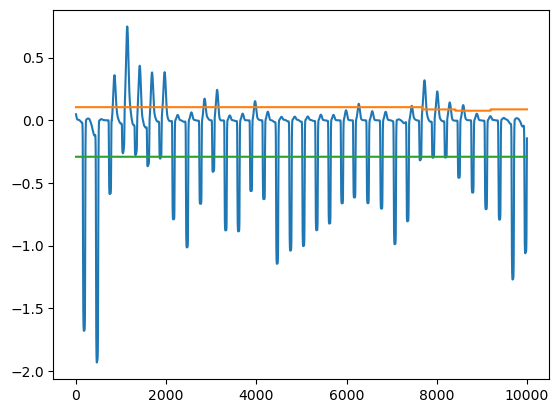

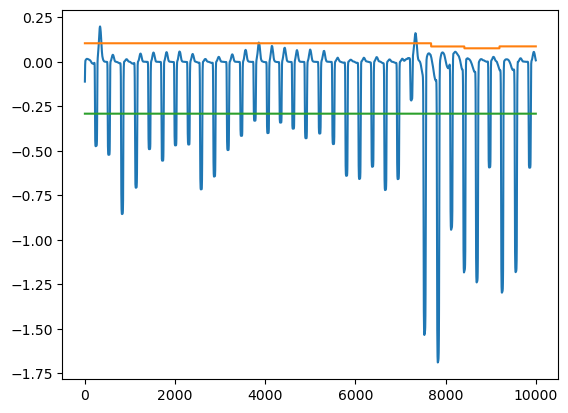

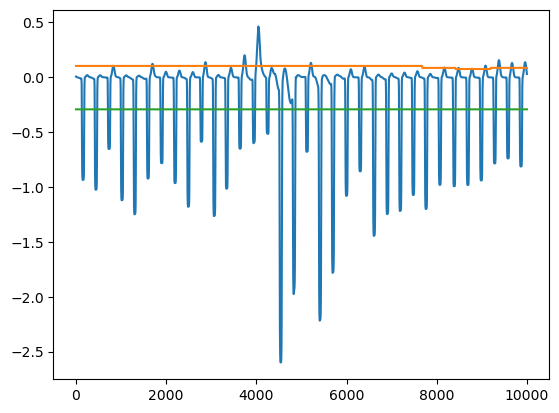

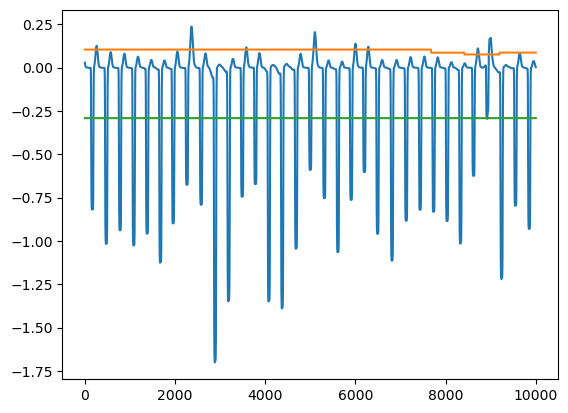

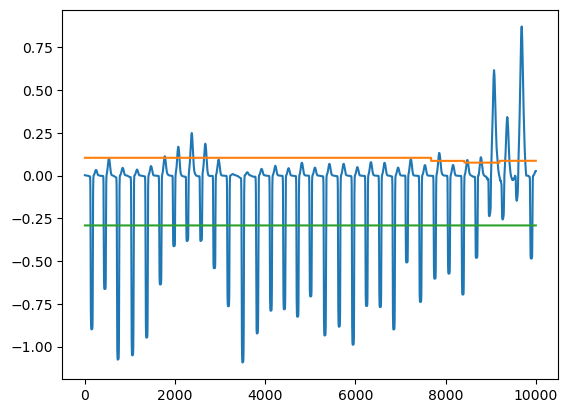

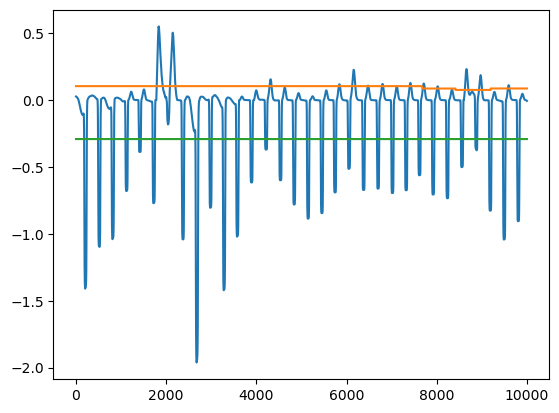

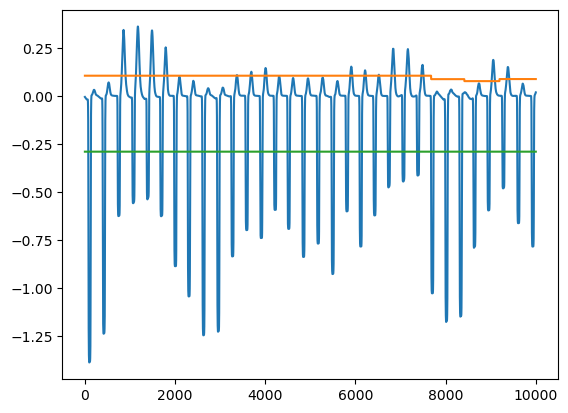

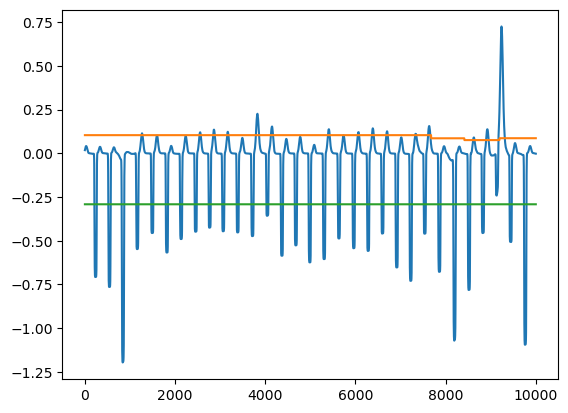

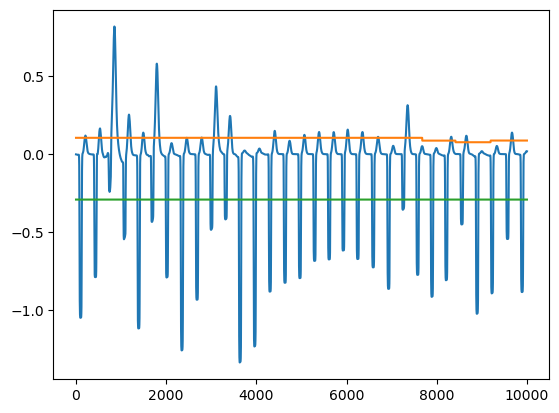

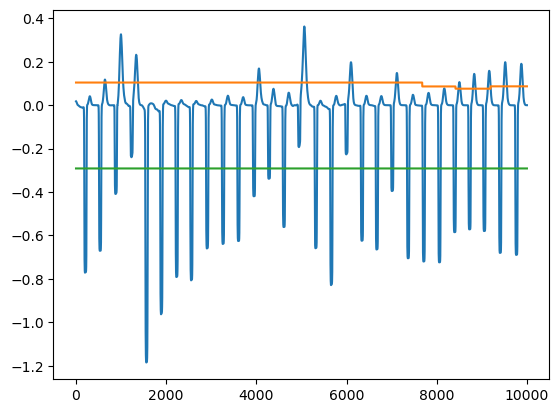

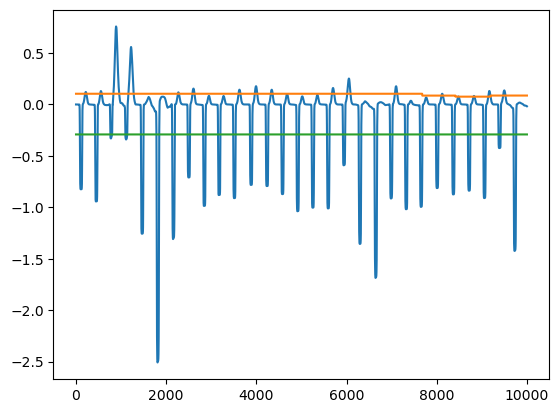

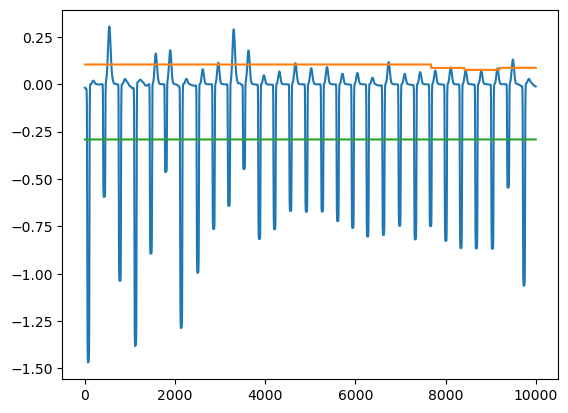

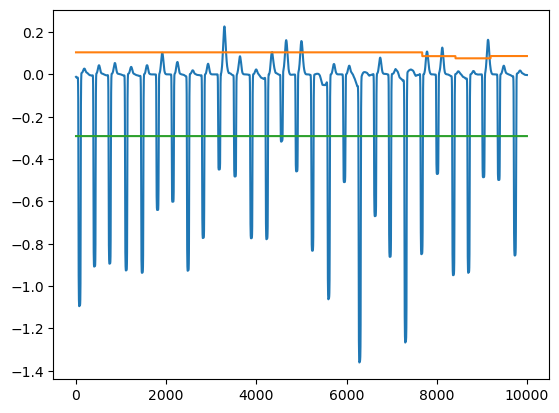

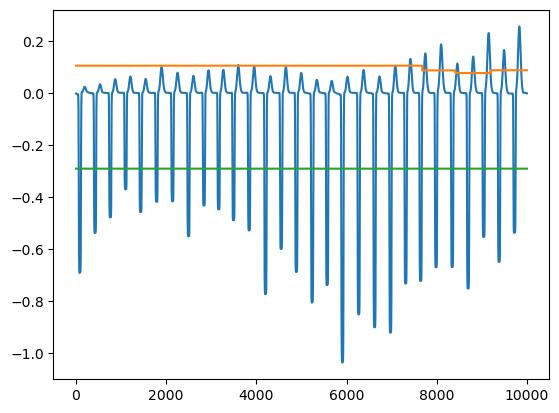

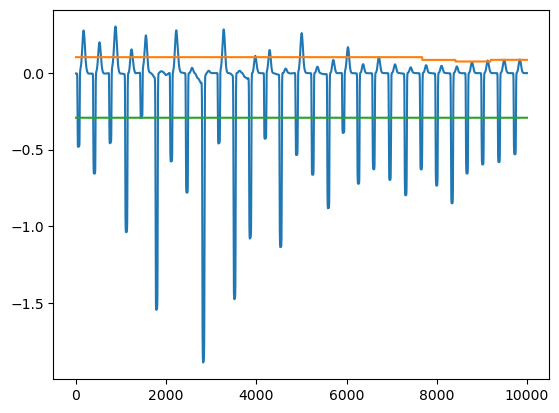

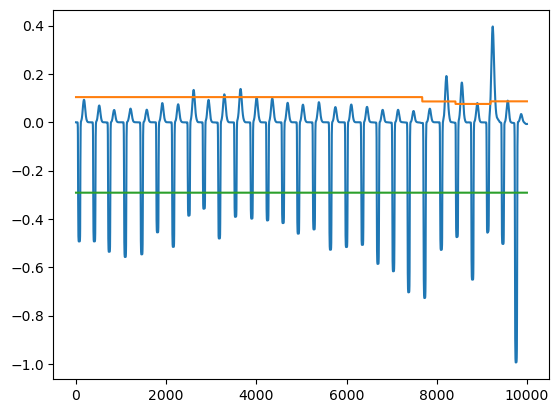

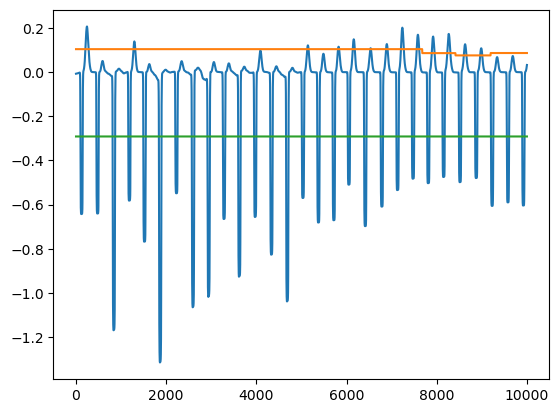

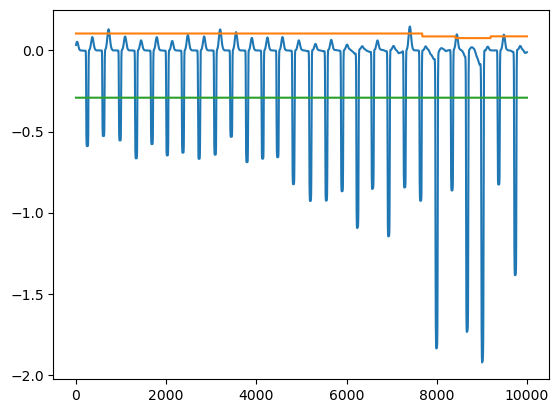

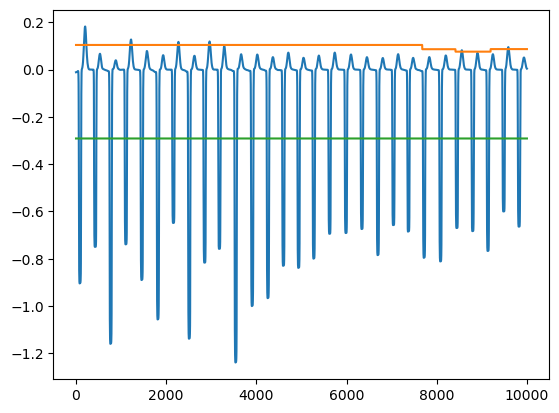

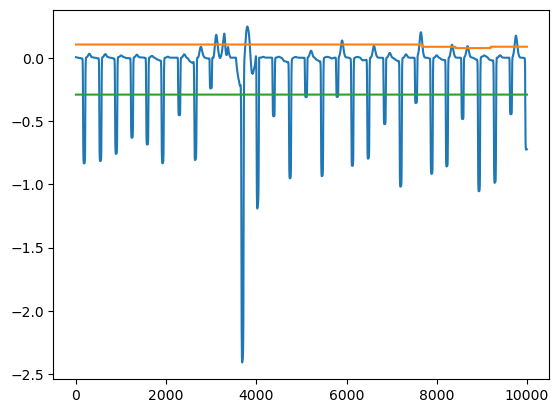

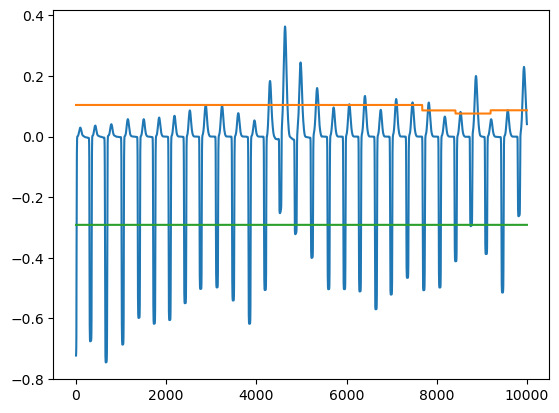

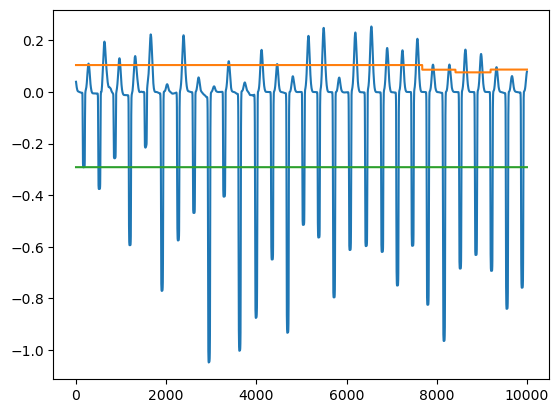

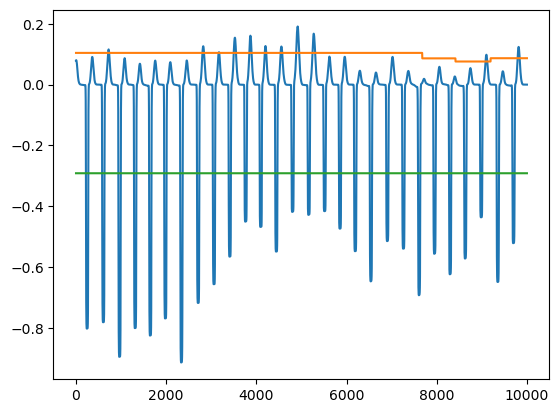

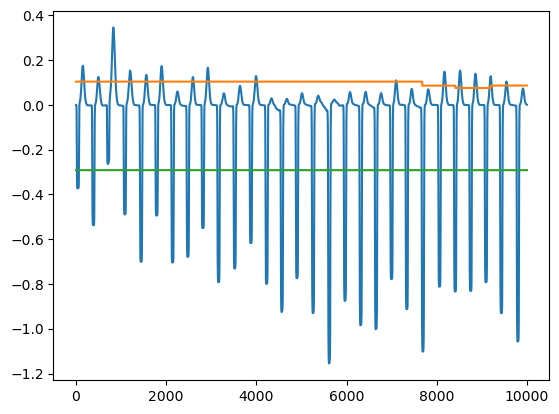

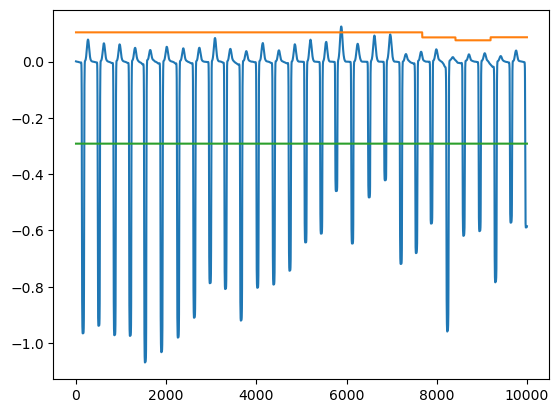

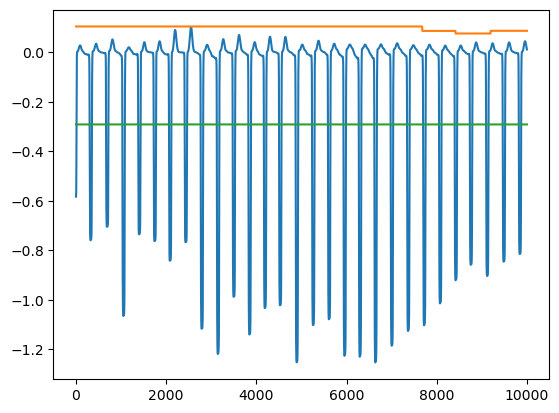

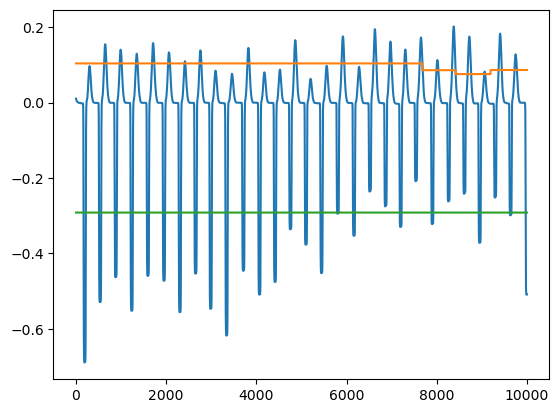

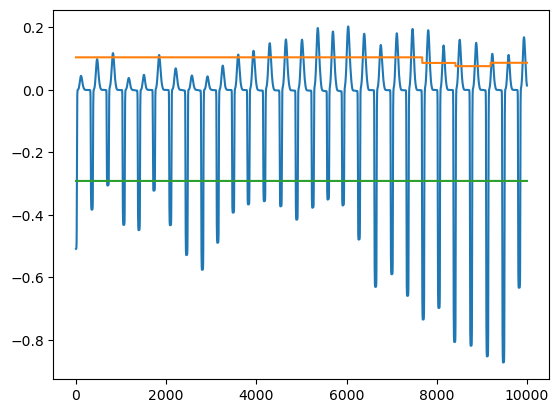

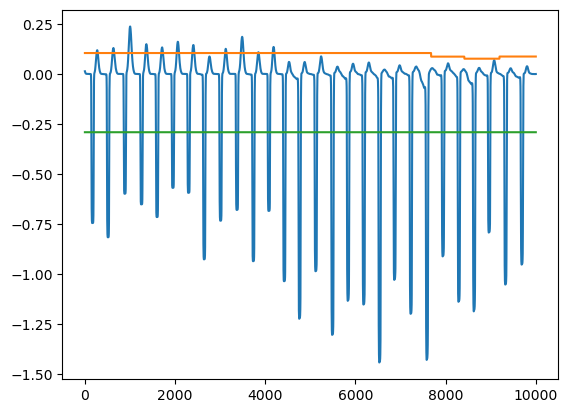

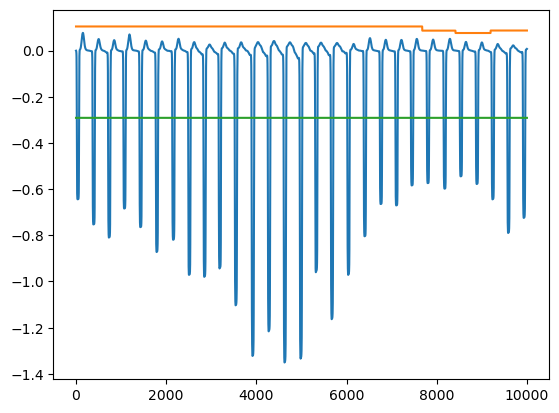

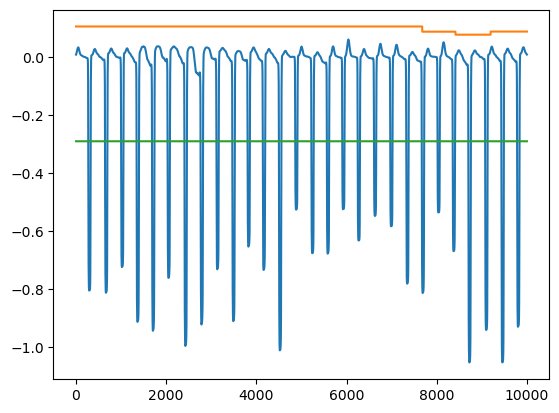

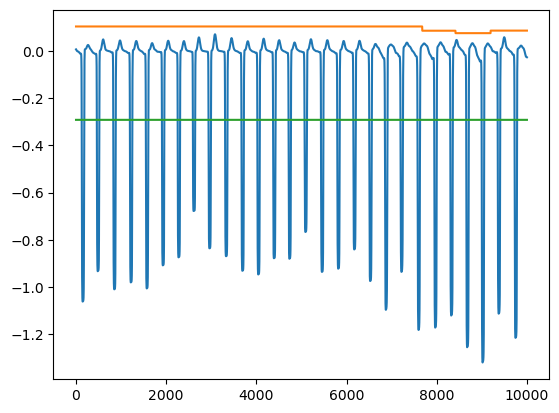

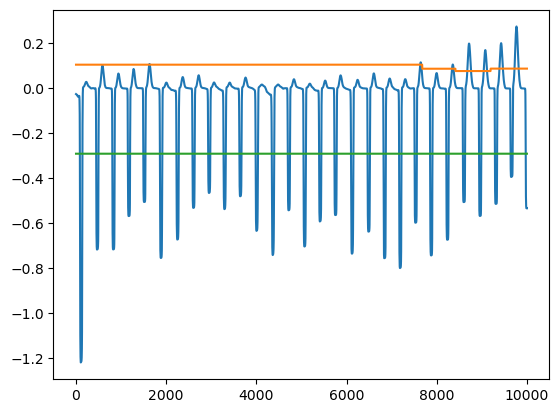

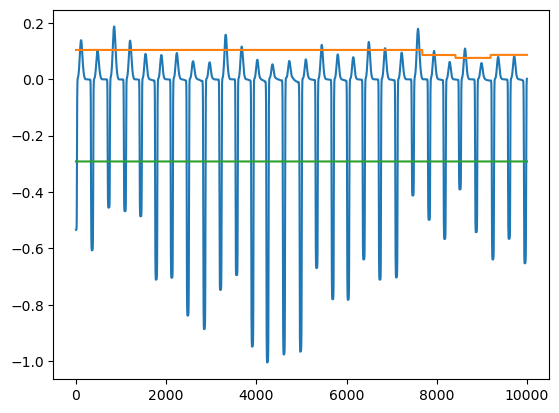

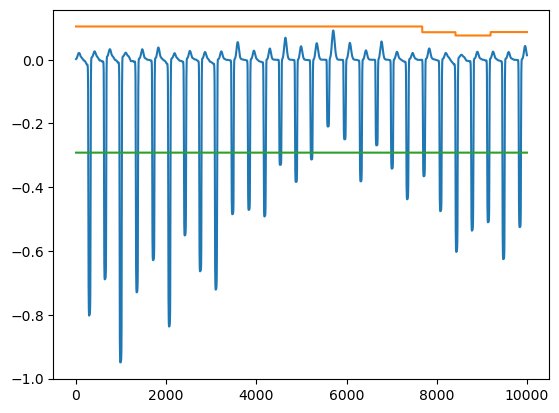

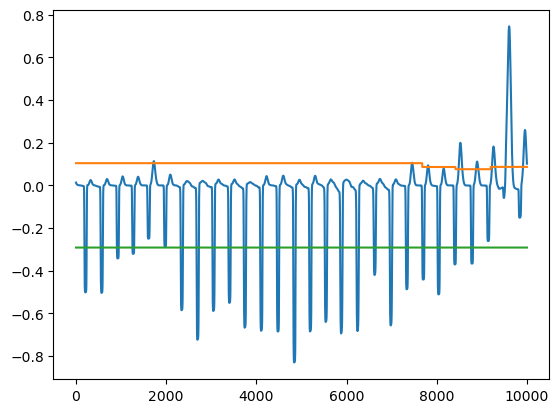

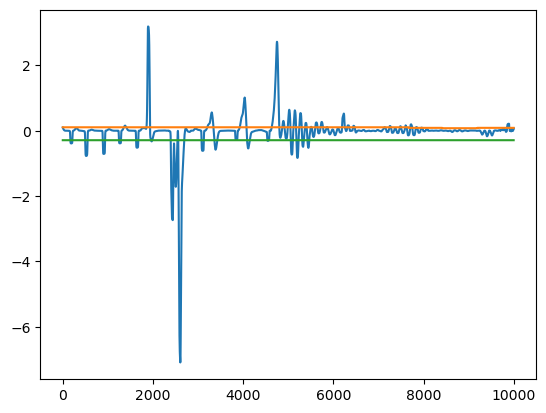

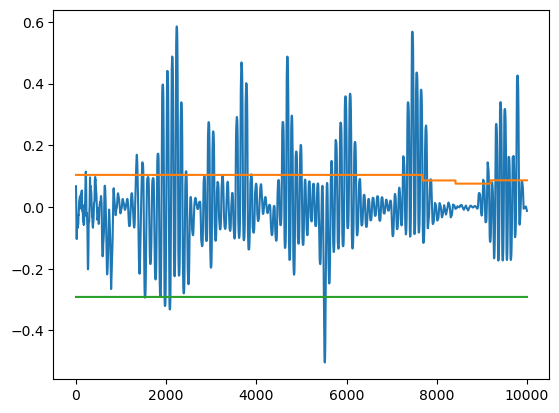

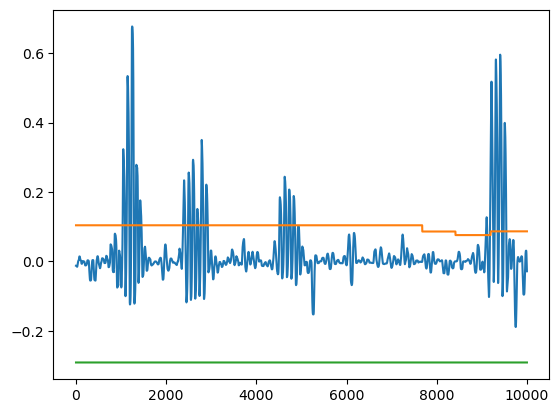

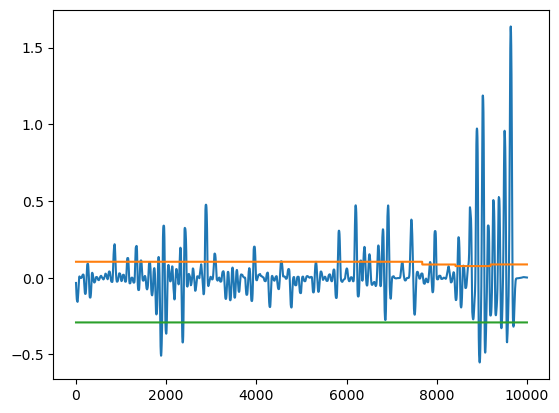

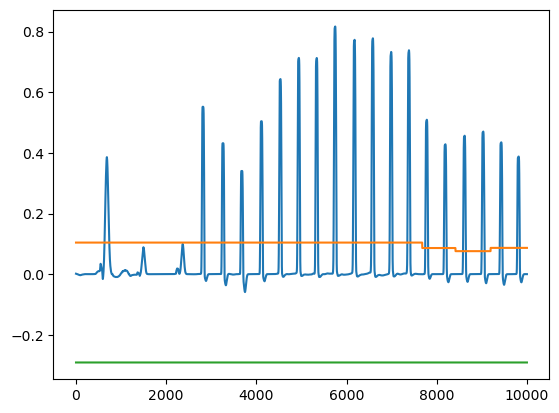

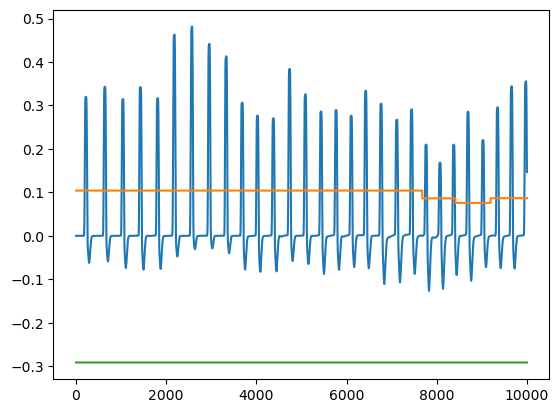

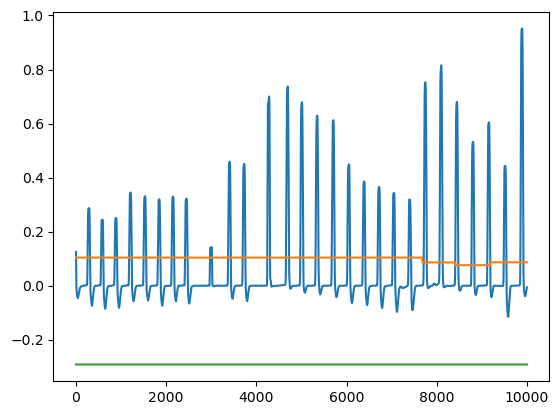

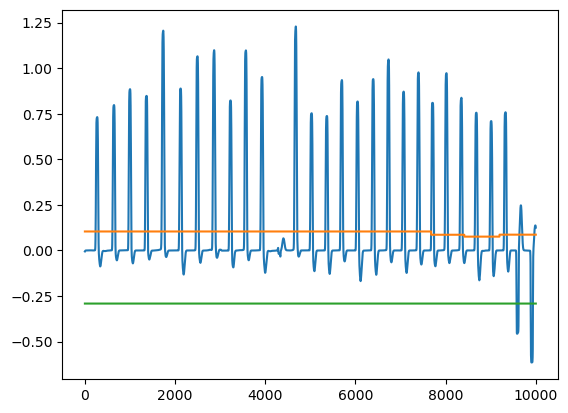

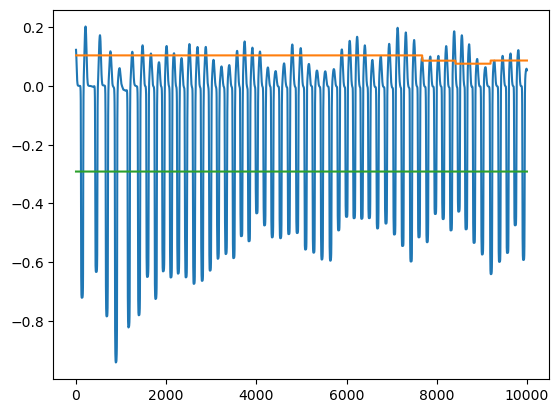

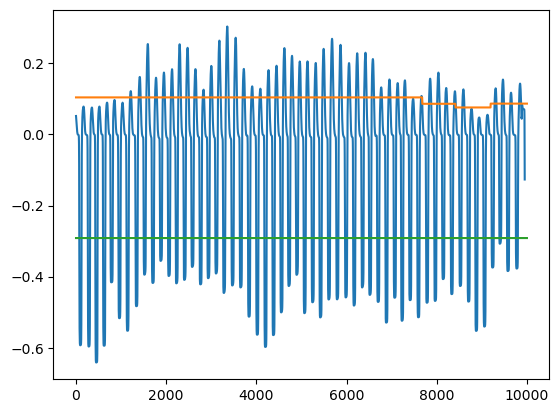

In [245]:
abon = 10000
for i in range(0, len(final_signal), abon):
    plt.figure()
    plt.plot(final_signal[i:i+abon])
    plt.plot(seuil_up[:abon])
    plt.plot(seuil_d[:abon])
    plt.show()

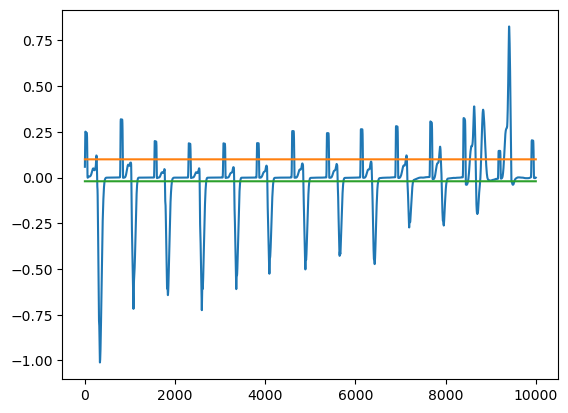

In [187]:
plt.figure()
plt.plot(final_signal[:10000])
plt.plot(seuil_up[:10000])
plt.plot(seuil_d[:10000])
plt.show()

In [166]:
# 0.12 = 2266, 7, 8,
# 0.1 = 2262, 14, 12,
# 0.08 = 2265, 13, 9,
# 

signal de longueur: 649951


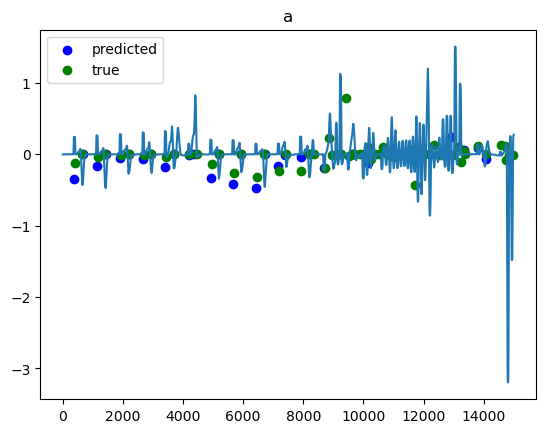

In [170]:
print_signal_qrs(final_signal, r_peaks, QRS, 5000, 20000)

In [ ]:
perf(QRS, qrs_localization(np.abs(final_signal), 0.05), 36)

In [23]:
r_peaks_true

[546800, 582956]

In [134]:
def qrs_localization(h, threshold):
    qrs_indices = []
    sous_groupe = []
    for i in range(len(h)):
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= (fs//10): # 36 = valeur donnée dans l'article
            qrs_indices.append(int(np.median(sous_groupe)))
            #max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(int(np.median(sous_groupe)))
        #max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

signal de longueur: 10000


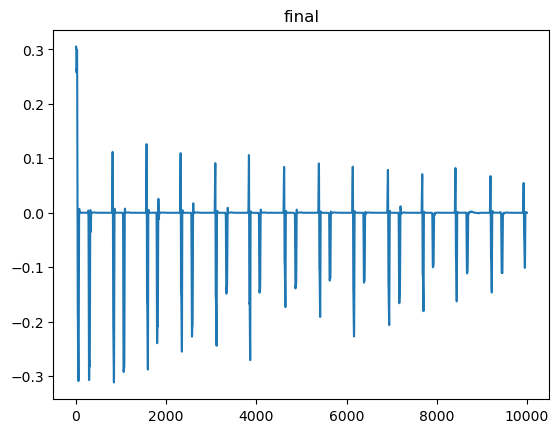

In [8]:
print_signal(final_signal[:10000], "final")

In [84]:
def QRS_detector(signal, fs):
    group_width=0.36

    three_seconds = signal[:int(3 * fs)]
    
    frequency, bin_edges = np.histogram(three_seconds, bins=np.arange(min(three_seconds), max(three_seconds) + group_width, group_width))
    
    fd = frequency / group_width
    
    mu = np.max(fd)
    
    mu_index = np.argmax(fd)
    
    center_value_of_mu = (bin_edges[mu_index] + bin_edges[mu_index + 1]) / 2
    
    Base_i = center_value_of_mu / 4

    thi = rms(signal[:fs*3])

    thu = np.mean(signal)
    thd = Base_i - thi
    
    r_peaks = qrs_localization(np.abs(signal), thu, thd)
    rr_mean = np.mean(np.diff(signal))

    #XOXO = 45000
    #mini = 35000
    #print_signal_qrs_c(signal[mini:XOXO], [a - mini for a in r_peaks if a < XOXO and a > mini], [a - mini for a in QRS if a < XOXO and a > mini], description = 'a')
    #print([a - mini for a in r_peaks if a < XOXO and a > mini])
    #print([a - mini for a in QRS if a < XOXO and a > mini])
    #print(r_peaks)
    #print(perf(QRS, r_peaks, 36)[:-1])

    thu = Base_i + (thi/2)
    thd = Base_i - thi

    true_peaks = r_peaks[:5]
    Beat = 5
    for i in r_peaks:
        print(i)
        peak_loc = i 
        peak = signal[i]
        if signal[i] >= thu:
            PRPamp, PRP = peak, peak_loc
            if Beat > 4:
                if PRP(i) - PRP(i-1) > 1.5 * RR_mean:
                    [peak_temp, loc_temp] = max( signal[ peak[Beat] + int(0.3*fs):peak[i] - int(0.3*fs)])
                    if peak_temp >= thu:
                        alpha = 0.125
                        thu_update(alpha, peak_temp, thu)
                        PRPamp, PRP = peak_temp, loc_temps
                    elif PRP(i) - PRP(i-1) < round(0.4 * fs):
                        alpha = 0.062
                        thu_update(alpha, peak_temp, thu)
                        PRP = 0
                        PRPamp = 0
        elif peak(i) < thd:
            PRPamp, PRP = peak, peak_loc
            if Beat > 4:
                if PRP[i] - PRP[i-1] > round(0.4*fs):
                    PRP = 0
                    PRPamp = 0

QRS_detector(final_signal, fs)

TypeError: qrs_localization() takes 2 positional arguments but 3 were given